In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from utils import create_dataloader

### Creating config object (argparse workaround)

In [3]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [41]:
dataloader = create_dataloader(config)

### Create generator and discriminator

In [48]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28))
            #nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)) 
            #nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [49]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [53]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

#criterion = nn.BCELoss()
criterion = nn.MSELoss()

### Create necessary variables

In [54]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN

2) Поменяйте ее, чтобы получился LSGAN и WGAN

3) Реализуйте AAE.

4) Попробуйте полученные модели на CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

5) Сравните полученные результаты. 


### GAN

In [55]:
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input = Variable(torch.FloatTensor(images.view(16, 28*28)))
        output = discriminator(input)
        print(output)
        print(label)
        errD_x = criterion(output, label)
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.data[0],
                                                                                            errD_z.data[0], 
                                                                                            errG.data[0]))

tensor([[-0.1387],
        [-0.1351],
        [-0.1191],
        [-0.1227],
        [-0.1294],
        [-0.1225],
        [-0.1228],
        [-0.1446],
        [-0.1219],
        [-0.1147],
        [-0.1264],
        [-0.1149],
        [-0.1114],
        [-0.1288],
        [-0.1454],
        [-0.1289]])
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.])


RuntimeError: input and target shapes do not match: input [16 x 1], target [16] at c:\users\administrator\downloads\new-builder\win-wheel\pytorch\aten\src\thnn\generic/MSECriterion.c:13

In [12]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=200, out_features=50, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=50, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [13]:
input.shape

torch.Size([16, 784])

In [14]:
input.shape

torch.Size([16, 784])

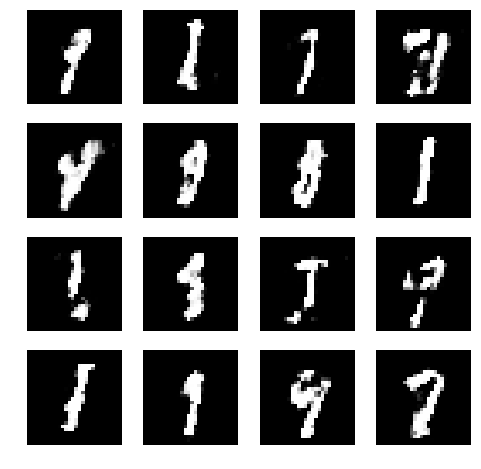

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

res = generator(noise).data
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(res[i].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
# plt.imshow(lsgenerator(noise).data[0].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)